# Testing out Turing.jl and LV demo using ModelingToolkit
Following [demo code](https://turing.ml/dev/tutorials/10-bayesian-differential-equations/) examples but convertted to use [ModelingToolkit.jl](https://github.com/SciML/ModelingToolkit.jl). Code fails on call to sample with an error about FunctionWrappers.

This notebook follows on from ```21_LV_demo.ipynb```

In [1]:
using Turing
using DifferentialEquations, ModelingToolkit

# Load StatsPlots for visualizations and diagnostics.
using StatsPlots

using LinearAlgebra

# Used for discarding warnings
using Logging: with_logger, NullLogger

# Set a seed for reproducibility.
using Random
Random.seed!(13);

[ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
┌ Warning: Replacing docs for `SciMLOperators.AbstractSciMLOperator :: Union{}` in module `SciMLOperators`
└ @ Base.Docs docs/Docs.jl:240
┌ Warning: Replacing docs for `SciMLBase.sol :: Union{Tuple, Tuple{D}, Tuple{S}, Tuple{N}, Tuple{T}} where {T, N, S, D}` in module `SciMLBase`
└ @ Base.Docs docs/Docs.jl:240
[ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
[ Info: Precompiling NamedArrays [86f7a689-2022-50b4-a561-43c23ac3c673]
[ Info: Precompiling ModelingToolkit [961ee093-0014-501f-94e3-6117800e7a78]
[ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
[ Info: GR


## ModelingToolkit.jl setup

In [2]:
@parameters t, alpha, beta, gamma, delta
D= Differential(t)
@variables  x(t), y(t)

eqs = [
    D(x) ~ (alpha - beta * y) * x # prey
    D(y) ~ (delta * x - gamma) * y # predator
]

@named sys =  ODESystem(eqs)
lv_simp = structural_simplify(sys)

Model sys with 2 equations
States (2):
  x(t)
  y(t)
Parameters (4):
  beta
  alpha
  gamma
  delta
Incidence matrix:2×4 SparseArrays.SparseMatrixCSC{Num, Int64} with 6 stored entries:
 ×  ×  ×  ⋅
 ×  ×  ⋅  ×

## LV demo

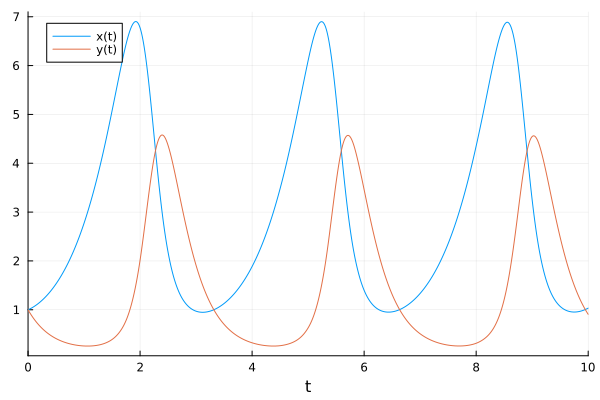

In [3]:
# Define initial-value problem.
u0 = Dict(x => 1.0, y=> 1.0)
p = Dict(alpha => 1.5, beta => 1.0, gamma => 3.0, delta => 1.0)
tspan = (0.0, 10.0)
prob = ODEProblem(lv_simp, u0, tspan, p)

# Plot simulation.
plot(solve(prob, Tsit5()))

## Making syntehtic observations

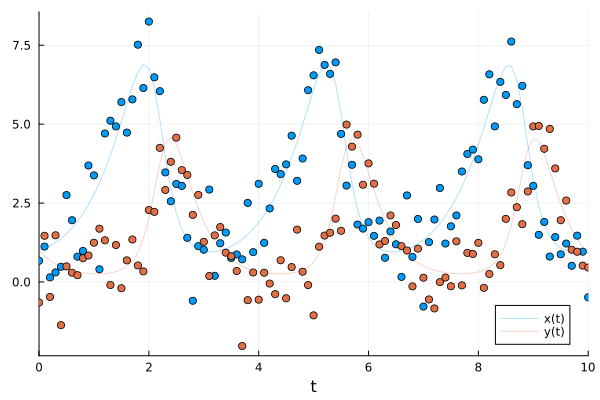

In [4]:
sol = solve(prob, Tsit5(); saveat=0.1)
odedata = Array(sol) + 0.8 * randn(size(Array(sol)))

# Plot simulation and noisy observations.
plot(sol; alpha=0.3)
scatter!(sol.t, odedata'; color=[1 2], label="")

## Fitting a model

In [5]:
@model function fitlv(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5, 0.5); lower=0.5, upper=2.5)
    β ~ truncated(Normal(1.2, 0.5); lower=0, upper=2)
    γ ~ truncated(Normal(3.0, 0.5); lower=1, upper=4)
    δ ~ truncated(Normal(1.0, 0.5); lower=0, upper=2)

    # Simulate Lotka-Volterra model. 
    #p = [α, β, γ, δ]
    p = Dict(alpha => α, beta => β, gamma => γ, delta => δ)
    predicted = solve(prob, Tsit5(); p=p, saveat=0.1)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end

model = fitlv(odedata, prob)

# Sample 3 independent chains with forward-mode automatic differentiation (the default).
# init_params=Iterators.repeated([0.31, 1.5, 0.95, 3.1, 1.0]),
chain = with_logger(NullLogger()) do
    sample(model, NUTS(0.65), MCMCSerial(), 1000, 3; progress=false)
end

Chains MCMC chain (1000×17×3 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 142.98 seconds
Compute duration  = 140.11 seconds
parameters        = σ, α, β, γ, δ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

           σ    1.2361    0.5748     0.0105    0.0771    6.0786    8.9675      ⋯
           α    1.4259    0.1447     0.0026    0.0170    8.1494    1.9893      ⋯
           β    1.0237    0.1108     0.0020    0.0103   12.7561    1.4058      ⋯
           γ    2.3761    0.8931     0.0163    0.1189    6.1483    6.5500      ⋯
           δ    0.8465    0.2136     0.0039    0.0275    

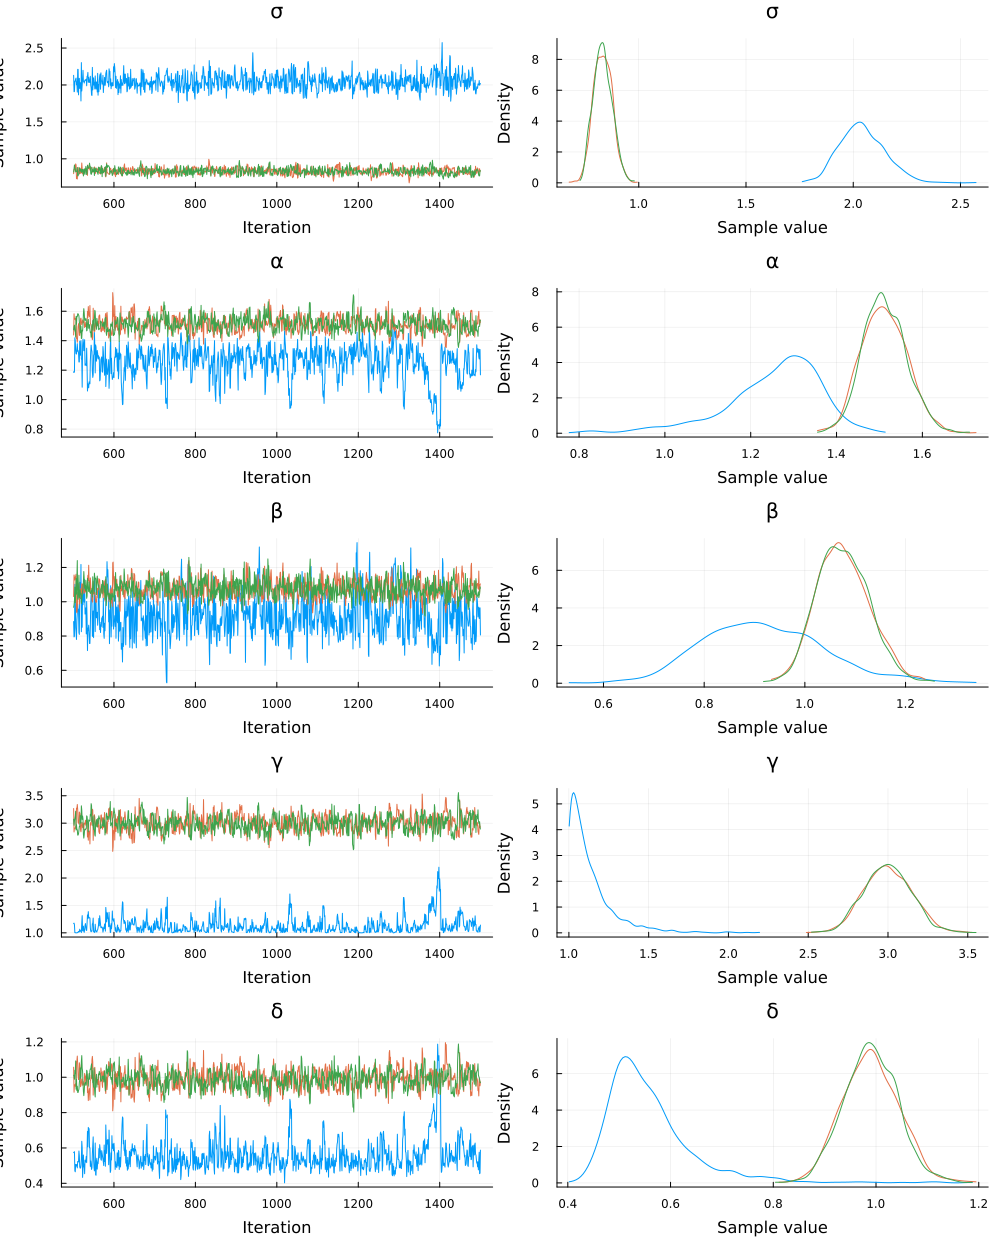

In [6]:
plot(chain)

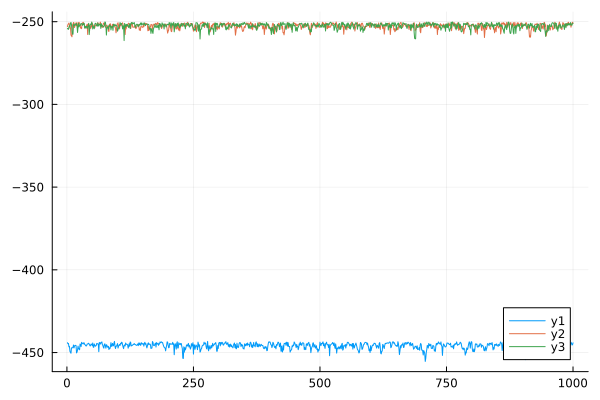

In [7]:
plot(chain[:lp])

In [8]:
using Pkg: Pkg
Pkg.status()

      Status `~/tmp/TuringExp.jl/Project.toml`
  [0c46a032] DifferentialEquations v7.7.0
  [7073ff75] IJulia v1.24.0
  [961ee093] ModelingToolkit v8.47.0
  [1ed8b502] SciMLSensitivity v7.20.0
  [f3b207a7] StatsPlots v0.15.4
  [fce5fe82] Turing v0.22.0
  [e88e6eb3] Zygote v0.6.55
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random


In [9]:
using InteractiveUtils
versioninfo()

Julia Version 1.6.7
Commit 3b76b25b64 (2022-07-19 15:11 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, cascadelake)
